<a href="https://colab.research.google.com/github/JotaBlanco/TheValley/blob/main/Arboles/Clase_02_Arboles/02_C_%C3%81rboles_Decisi%C3%B3n_sin_Overfitting_Resuelto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 INTRO: Árboles de Decisión
Explicación de cómo construír árboles de decisión.

Notebook por [Javier Blanco Cordero](https://www.linkedin.com/in/javier-blanco-cordero-71373656/).

### Enlaces de interés
*   [Slides de presentación](https://docs.google.com/presentation/d/1iq5k6zECRldUv5so26OsvkExqFJUwKd_CZu18hB-MB8/edit#slide=id.gc2469ceed5_0_0)



## 0101 Qué es un árbol de decisión?
Un tipo de algoritmo de aprendizaje supervisado que se basa en realizar particiones a partir de distintos niveles de las variables disponibles.

## 0102 Import
Importamos todas las librerías necesarias para este análisis ([¿No sabes lo que es una librería de Python?](https://www.quora.com/What-is-a-Python-library-and-what-can-I-use-it-for)): pandas, numpy, seaborn, matplotlib.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz 
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

## 0103 Carga el dataset de coches de segunda mano
Para probar a hacer árboles de decisión sin overfitting utilizaremos un dataset sobre el precio de distintos coches de segunda mano que he encontrado en Kaggle ([aquí](https://www.kaggle.com/harturo123/online-adds-of-used-cars)). 

Podéis encontrar el archivo listo para importar en mi github: 'https://raw.githubusercontent.com/JotaBlanco/TheValley/main/Data/coches_usados_esp.csv'. 

Importa este dataset en un dataframe llamado **df**.

In [2]:
# Url archivo raw
url = 'https://raw.githubusercontent.com/JotaBlanco/TheValley/main/Data/coches_usados_esp.csv'

# Importa csv
df = pd.read_csv(url, sep=';')

# Visualización primeras filas
df.head()

,ID,make,model,version,months_old,power,sale_type,num_owners,gear_type,fuel_type,kms,price
0,97860,Porsche,911,Carrera 4 S Coup�,240.0,210.0,classic,3.0,manual,gasoline,202000.0,999999
1,27821,Ford,Mustang,Gt500 Cabrio Vendido,54.0,487.0,used,1.0,manual,gasoline,30000.0,685000
2,97801,Porsche,911,3.3 Turbo Targa (Precio A Consultar),358.0,220.0,used,NaN,manual,gasoline,56300.0,555555
3,98251,Porsche,911,R Unidad 343 De 991-Iva Deducible,14.0,368.0,used,1.0,manual,gasoline,2800.0,470000
4,98250,Porsche,911,Gt2 Rs,3.0,515.0,used,NaN,NaN,gasoline,10.0,450000


# 02 EDA
Realizaremos un pequeño análisis exploratorio visual para familiarizarnos con el dataset. 

Recuerda que puedes encontrar mis clases sobre análisis exploratorio [aquí](https://github.com/JotaBlanco/TheValley/tree/main/EDA/).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93991 entries, 0 to 93990
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          93991 non-null  int64  
 1   make        93991 non-null  object 
 2   model       93991 non-null  object 
 3   version     93991 non-null  object 
 4   months_old  93717 non-null  float64
 5   power       93504 non-null  float64
 6   sale_type   93979 non-null  object 
 7   num_owners  22660 non-null  float64
 8   gear_type   92710 non-null  object 
 9   fuel_type   93926 non-null  object 
 10  kms         93127 non-null  float64
 11  price       93991 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 8.6+ MB


In [4]:
df.isna().sum()

ID                0
make              0
model             0
version           0
months_old      274
power           487
sale_type        12
num_owners    71331
gear_type      1281
fuel_type        65
kms             864
price             0
dtype: int64

In [5]:
df.describe()

,ID,months_old,power,num_owners,kms,price
count,93991.00000,93717.000000,93504.000000,22660.000000,93127.000000,93991.000000
mean,55100.87935,63.094775,99.729477,1.055119,82702.565250,16587.291379
std,33119.32602,56.837686,42.698809,0.277124,75186.697789,15563.712383
min,25.00000,1.000000,0.000000,1.000000,0.000000,200.000000
25%,25452.50000,16.000000,77.000000,1.000000,18300.000000,8500.000000
50%,53896.00000,46.000000,88.000000,1.000000,66000.000000,13490.000000
75%,83573.50000,96.000000,110.000000,1.000000,129000.000000,19999.000000
max,113143.00000,374.000000,809.000000,11.000000,497000.000000,999999.000000


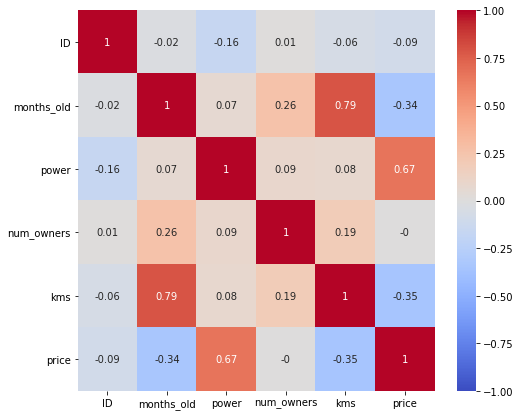

In [6]:
# Visualización coeficientes Pearson
plt.figure(figsize=(8,7))
sns.heatmap(np.round(df.corr(),2), 
            vmin=-1, vmax=1, 
            annot=True, cmap="coolwarm")
plt.show()

# 03 EJEMPLO
Vamos a ver paso a paso cómo realizar un modelo que prediga el precio sin caer en overfitting.

## 0301 Preparamos los datos
El dataframe tiene algunos nulos, así como variables categóricas y presencia de ciertas variables que probablemente no queramos usar.

### 030101 Variables Útiles
De entre las variables disponibles, veamos cuáles queremos utilizar como predictoras para el estudio.

In [7]:
df.head()

,ID,make,model,version,months_old,power,sale_type,num_owners,gear_type,fuel_type,kms,price
0,97860,Porsche,911,Carrera 4 S Coup�,240.0,210.0,classic,3.0,manual,gasoline,202000.0,999999
1,27821,Ford,Mustang,Gt500 Cabrio Vendido,54.0,487.0,used,1.0,manual,gasoline,30000.0,685000
2,97801,Porsche,911,3.3 Turbo Targa (Precio A Consultar),358.0,220.0,used,NaN,manual,gasoline,56300.0,555555
3,98251,Porsche,911,R Unidad 343 De 991-Iva Deducible,14.0,368.0,used,1.0,manual,gasoline,2800.0,470000
4,98250,Porsche,911,Gt2 Rs,3.0,515.0,used,NaN,NaN,gasoline,10.0,450000


In [8]:
df.columns

Index(['ID', 'make', 'model', 'version', 'months_old', 'power', 'sale_type',
       'num_owners', 'gear_type', 'fuel_type', 'kms', 'price'],
      dtype='object')

In [9]:
cols = ['make', 'model', 'months_old', 'power', 'sale_type', 'num_owners', 
        'gear_type', 'fuel_type', 'kms', 'price']

### 030102 Dumificación de variables categóricas

In [10]:
df_i = pd.get_dummies(df[cols], 
                   prefix_sep='_', 
                   drop_first=True, 
                   columns=['make', 'model', 'sale_type', 'gear_type', 'fuel_type'])

display(len(df_i))
df_i.head()

93991

,months_old,power,num_owners,kms,price,make_Audi,make_Bentley,make_Bmw,make_Chevrolet,make_Chrysler,make_Citroen,make_Dacia,make_Ds,make_Fiat,make_Ford,make_Honda,make_Hyundai,make_Iveco,make_Jaguar,make_Jeep,make_Kia,make_Land,make_Mazda,make_Mercedes-Benz,make_Mini,make_Mitsubishi,make_Nissan,make_Opel,make_Peugeot,make_Porsche,make_Renault,make_Saab,make_Seat,make_Skoda,make_Smart,make_Ssangyong,make_Suzuki,make_Toyota,make_Volkswagen,make_Volvo,...,model_V220,model_V40,model_V40Cc,model_V60,model_Vectra,model_Verso,model_Viano,model_Vito,model_Vivaro,model_Voyager,model_Wrangler,model_X-Trail,model_X1,model_X3,model_X4,model_X5,model_X6,model_Xc60,model_Xc90,model_Xe,model_Xf,model_Xsara,model_XsaraPicasso,model_Yaris,model_Z4,model_Zafira,model_ZafiraTourer,sale_type_classic,sale_type_demo,sale_type_km_0,sale_type_new,sale_type_used,gear_type_manual,gear_type_semi-automatic,fuel_type_LPG,fuel_type_diesel,fuel_type_electric,fuel_type_etanol,fuel_type_gasoline,fuel_type_hybrid
0,240.0,210.0,3.0,202000.0,999999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,54.0,487.0,1.0,30000.0,685000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
2,358.0,220.0,NaN,56300.0,555555,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
3,14.0,368.0,1.0,2800.0,470000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
4,3.0,515.0,NaN,10.0,450000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


### 030103 Limpieza de nulos
Con la dumificación hemos eliminado los nulos en las columnas categóricas sin deshacernos de las filas. Queda algún nulo en las variables numéricas?


In [11]:
df_i.columns

Index(['months_old', 'power', 'num_owners', 'kms', 'price', 'make_Audi',
       'make_Bentley', 'make_Bmw', 'make_Chevrolet', 'make_Chrysler',
       ...
       'sale_type_new', 'sale_type_used', 'gear_type_manual',
       'gear_type_semi-automatic', 'fuel_type_LPG', 'fuel_type_diesel',
       'fuel_type_electric', 'fuel_type_etanol', 'fuel_type_gasoline',
       'fuel_type_hybrid'],
      dtype='object', length=299)

In [12]:
df_i[['months_old', 'power', 'num_owners', 'kms', 'price']].isna().sum()

months_old      274
power           487
num_owners    71331
kms             864
price             0
dtype: int64

In [13]:
# Hay muchos nulos en num_owners
# Quizás esto tiene que ver con origenes del coche desconocidos?
# Vamos a limpiar la variable en 1, 2, 3+, nulo y la utilizamos como categórica
filtro_muchos_owners = df_i['num_owners']>=3
df_i.loc[filtro_muchos_owners, 'num_owners'] = '3+'
df_i = pd.get_dummies(df_i, prefix_sep='_', 
                   dummy_na=True,
                   drop_first=True, 
                   columns=['num_owners'])
df_i.head()

,months_old,power,kms,price,make_Audi,make_Bentley,make_Bmw,make_Chevrolet,make_Chrysler,make_Citroen,make_Dacia,make_Ds,make_Fiat,make_Ford,make_Honda,make_Hyundai,make_Iveco,make_Jaguar,make_Jeep,make_Kia,make_Land,make_Mazda,make_Mercedes-Benz,make_Mini,make_Mitsubishi,make_Nissan,make_Opel,make_Peugeot,make_Porsche,make_Renault,make_Saab,make_Seat,make_Skoda,make_Smart,make_Ssangyong,make_Suzuki,make_Toyota,make_Volkswagen,make_Volvo,model_118,...,model_V60,model_Vectra,model_Verso,model_Viano,model_Vito,model_Vivaro,model_Voyager,model_Wrangler,model_X-Trail,model_X1,model_X3,model_X4,model_X5,model_X6,model_Xc60,model_Xc90,model_Xe,model_Xf,model_Xsara,model_XsaraPicasso,model_Yaris,model_Z4,model_Zafira,model_ZafiraTourer,sale_type_classic,sale_type_demo,sale_type_km_0,sale_type_new,sale_type_used,gear_type_manual,gear_type_semi-automatic,fuel_type_LPG,fuel_type_diesel,fuel_type_electric,fuel_type_etanol,fuel_type_gasoline,fuel_type_hybrid,num_owners_2.0,num_owners_3+,num_owners_nan
0,240.0,210.0,202000.0,999999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
1,54.0,487.0,30000.0,685000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0
2,358.0,220.0,56300.0,555555,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1
3,14.0,368.0,2800.0,470000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0
4,3.0,515.0,10.0,450000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [14]:
df_i[['months_old', 'power', 'kms', 'price']].isna().sum()

months_old    274
power         487
kms           864
price           0
dtype: int64

In [15]:
for col in ['months_old', 'power', 'kms']:
  df_i[col] = df_i[col].fillna(df_i[col].median())

In [16]:
df_i.isna().sum()

months_old            0
power                 0
kms                   0
price                 0
make_Audi             0
                     ..
fuel_type_gasoline    0
fuel_type_hybrid      0
num_owners_2.0        0
num_owners_3+         0
num_owners_nan        0
Length: 301, dtype: int64

##0302 Train - test split
Separamos el set de datos en dos utilizando [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).


In [17]:
X = df_i.drop('price',axis=1)
y = df_i['price']

len(X), len(y)

(93991, 93991)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 0303 Entrenamos el árbol de decisión
Sobre el set de entrenamiento, comprobamos el modelo sobre el set de test.
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor

In [19]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=10)
# Entreno el árbol con el set de entrenamiento
modelo = modelo.fit(X=X_train, y=y_train)
# Uso el árbol para predecir sobre el dataset de entrenamiento
y_pred_train = modelo.predict(X_train)
# Uso el árbol para predecir sobre el dataset de test
y_pred_test = modelo.predict(X_test)
# Cómo de buena es la predicción?
print('RMSE en set de entrenamiento :', mean_squared_error(y_train, y_pred_train, squared=False))
print('RMSE en set de test :', mean_squared_error(y_test, y_pred_test, squared=False))

RMSE en set de entrenamiento : 4212.870964705138
RMSE en set de test : 5617.484313904153


In [20]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=5)
# Entreno el árbol con el set de entrenamiento
modelo = modelo.fit(X=X_train, y=y_train)
# Uso el árbol para predecir sobre el dataset de entrenamiento
y_pred_train = modelo.predict(X_train)
# Uso el árbol para predecir sobre el dataset de test
y_pred_test = modelo.predict(X_test)
# Cómo de buena es la predicción?
print('RMSE en set de entrenamiento :', mean_squared_error(y_train, y_pred_train, squared=False))
print('RMSE en set de test :', mean_squared_error(y_test, y_pred_test, squared=False))

RMSE en set de entrenamiento : 7140.0614444012435
RMSE en set de test : 7299.206539578955


In [21]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=50)
# Entreno el árbol con el set de entrenamiento
modelo = modelo.fit(X=X_train, y=y_train)
# Uso el árbol para predecir sobre el dataset de entrenamiento
y_pred_train = modelo.predict(X_train)
# Uso el árbol para predecir sobre el dataset de test
y_pred_test = modelo.predict(X_test)
# Cómo de buena es la predicción?
print('RMSE en set de entrenamiento :', mean_squared_error(y_train, y_pred_train, squared=False))
print('RMSE en set de test :', mean_squared_error(y_test, y_pred_test, squared=False))

RMSE en set de entrenamiento : 375.8288396572212
RMSE en set de test : 5768.494114957268


In [22]:
def entrenar_modelo_y_predecir(modelo):
  # Entreno el árbol con el set de entrenamiento
  modelo = modelo.fit(X=X_train, y=y_train)
  # Uso el árbol para predecir sobre el dataset de entrenamiento
  y_pred_train = modelo.predict(X_train)
  # Uso el árbol para predecir sobre el dataset de test
  y_pred_test = modelo.predict(X_test)
  # Cómo de buena es la predicción?
  print('RMSE en set de entrenamiento :', mean_squared_error(y_train, y_pred_train, squared=False))
  print('RMSE en set de test :', mean_squared_error(y_test, y_pred_test, squared=False))

In [23]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=25)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 1126.7576194805622
RMSE en set de test : 5637.3468823076655


## 0304 Probamos medidas contra el overfitting

### 030401 min_samples_split
Tamaño muestral mínimo para permitir una partición.

In [24]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=10, min_samples_split=20)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 5767.079011141262
RMSE en set de test : 5809.845691254969


In [25]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=15, min_samples_split=20)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 5157.930973566497
RMSE en set de test : 5547.623325009855


In [26]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=15, min_samples_split=25)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 5233.351078575654
RMSE en set de test : 5517.895840048824


### 030402 min_samples_leaf
Tamaño muestral mínimo en una hoja.

In [27]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=15, 
                                    min_samples_split=25,
                                    min_samples_leaf = 10)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 6399.307655212139
RMSE en set de test : 5866.712812899478


In [28]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=20, 
                                    min_samples_split=20,
                                    min_samples_leaf = 2)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 5467.303845297351
RMSE en set de test : 5775.201237733983


### 030402 min_impurity_decrease
Mínimo descenso de impuridad.

In [29]:
# Inicializo un árbol
modelo = tree.DecisionTreeRegressor(max_depth=15, 
                                    min_samples_split=25,
                                    min_impurity_decrease = 0.25)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir(modelo)

RMSE en set de entrenamiento : 5233.351078575654
RMSE en set de test : 5521.5297779704415


# 06 EJERCICIO TITANIC
Recordais el dataset del Titanic?

Vamos a resolver este problema teniendo en cuenta todo lo que sabemos ya. El objetivo es crear una árbol de decisión que prediga si un pasajero falleció o no (pasajeros cuyos datos no conocemos todavía).

Toma las medidas oportunas para que tu modelo sea lo más preciso posible sin caer en overfitting.

## 0601 Importa el dataset
Puedes encontrarlo en mi github. Este es el link al archivo raw: https://raw.githubusercontent.com/JotaBlanco/TheValley/main/Data/titanic.csv.

Importa los datos en un dataframe llamado dataframe **df_titanic**.

In [68]:
# Url archivo raw
url = 'https://raw.githubusercontent.com/JotaBlanco/TheValley/main/Data/titanic.csv'

# Importa csv
df_titanic = pd.read_csv(url)

# Visualización primeras filas
df_titanic.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## 0602 Prepara los datos
Quédate con las variables interesantes, dumifica las categóricas y limpia los nulos.

In [69]:
# Creamos una nueva variable Título (esto es opcional, pero podría ayudar al modelo)
df_titanic['Title'] = [name.split(",")[1].split(".")[0][1:] for name in df_titanic['Name']]

In [70]:
df_titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title'],
      dtype='object')

In [71]:
# Descartamos ciertas columnas con oel nombre, o la cabina
# Tienen muchas posibles categorías, pero deberían ser buenas para predecir el target 
# sobre datos no vistos
cols = ['Survived', 
        'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title']
cat_cols = ['Sex', 'Embarked', 'Title']

In [72]:
df_titanic[cols].head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [73]:
# Rellenamos los nulos de las variables numéricas (edad)
df_titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [74]:
filtro_edad_nula = df_titanic['Age'].isna()
filtro_edad_no_nula = df_titanic['Age'].notnull()

# Rellenamos los nulos 
for titulo in df_titanic['Title'].unique():
  filtro_titulo = df_titanic['Title'] == titulo

  if len(df_titanic[((filtro_titulo) & (filtro_edad_no_nula))]) > 2:
    print(titulo)
    df_titanic.loc[((filtro_titulo)&(filtro_edad_nula)), 'Age'] = df_titanic.loc[((filtro_titulo)&(filtro_edad_no_nula)), 'Age'].median()
  
# Rellenamos los que sigan siendo nulos (títulos solo presentes entre gente sin la edad informada)
df_titanic['Age'] = df_titanic['Age'].fillna(df_titanic['Age'].median())

Mr
Mrs
Miss
Master
Rev
Dr


In [75]:
# Dumificamos variables categóricas
df_titanic_i = pd.get_dummies(df_titanic[cols], 
                              prefix_sep='_',
                              drop_first=True, 
                              columns=cat_cols)
df_titanic_i.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Col,Title_Don,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,0,3,22.0,1,0,7.2500,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,1,38.0,1,0,71.2833,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,3,35.0,0,0,8.0500,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [77]:
df_titanic_i.isna().sum()

Survived              0
Pclass                0
Age                   0
SibSp                 0
Parch                 0
Fare                  0
Sex_male              0
Embarked_Q            0
Embarked_S            0
Title_Col             0
Title_Don             0
Title_Dr              0
Title_Jonkheer        0
Title_Lady            0
Title_Major           0
Title_Master          0
Title_Miss            0
Title_Mlle            0
Title_Mme             0
Title_Mr              0
Title_Mrs             0
Title_Ms              0
Title_Rev             0
Title_Sir             0
Title_the Countess    0
dtype: int64

## 0603 Train - test split
Utiliza una partición del 30% para tu set de pruebas.

In [78]:
X = df_titanic_i.drop('Survived',axis=1)
y = df_titanic_i['Survived']

len(X), len(y)

(891, 891)

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

## 0404 Entrena varios árboles
Entrena varios árboles de decisión controlando los distintos parámetros para buscar el punto óptimo entre bias y varianza.

In [84]:
def entrenar_modelo_y_predecir_classificacion(modelo):
  # Entreno el árbol con el set de entrenamiento
  modelo = modelo.fit(X=X_train, y=y_train)
  # Uso el árbol para predecir sobre el dataset de entrenamiento
  y_pred_train = modelo.predict(X_train)
  # Uso el árbol para predecir sobre el dataset de test
  y_pred_test = modelo.predict(X_test)
  # Cómo de buena es la predicción?
  ac_train = round(accuracy_score(y_train, y_pred_train), 4)
  print('Precisión en set de entrenamiento :', ac_train)
  ac_test = round(accuracy_score(y_test, y_pred_test), 4)
  print('Precisión en set de test :', ac_test)
  print('Degradación: ', round((ac_train-ac_test)/ac_train*100,2), '%')

In [86]:
# Inicializo un árbol con 10 de profundidad
modelo = tree.DecisionTreeClassifier(max_depth=10)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

Precisión en set de entrenamiento : 0.9346
Precisión en set de test : 0.8
Degradación:  14.4 %


In [87]:
# Más profundidad = overfitting
modelo = tree.DecisionTreeClassifier(max_depth=20)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

Precisión en set de entrenamiento : 0.9782
Precisión en set de test : 0.7661
Degradación:  21.68 %


In [94]:
# Añadimos medidas contra overfitting
modelo = tree.DecisionTreeClassifier(max_depth=15, 
                                     min_samples_split=10)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

Precisión en set de entrenamiento : 0.9195
Precisión en set de test : 0.7695
Degradación:  16.31 %


In [110]:
# Añadimos medidas contra overfitting: reducimos profundidad
modelo = tree.DecisionTreeClassifier(max_depth = 4,
                                     min_samples_leaf = 2)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

Precisión en set de entrenamiento : 0.8322
Precisión en set de test : 0.8068
Degradación:  3.05 %


In [112]:
# Añadimos medidas contra overfitting: ampliamos mínima muestra en nodo terminal
modelo = tree.DecisionTreeClassifier(max_depth = 4,
                                     min_samples_leaf = 5)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

Precisión en set de entrenamiento : 0.8305
Precisión en set de test : 0.8102
Degradación:  2.44 %
